In [2]:
from scipy.stats import qmc
import pandas as pd
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import shutil
import os
import numpy as np
from scipy.integrate import simps
from sklearn.metrics import mean_squared_error
from math import sqrt
import subprocess
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import ListedColormap
import contextily as ctx
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")

C:\Users\RIPHAWK\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\RIPHAWK\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [163]:
def get_surfacesolarflux(run_folder):
    base_source_folder = run_folder
    control_file = pd.read_csv(os.path.join(base_source_folder, 'HeatSource_Control.csv'))

    cc_start = control_file.loc[7]['VALUE']
    cc_start = pd.to_datetime(cc_start)
    cc_end = control_file.loc[8]['VALUE']
    cc_end = pd.to_datetime(cc_end)

    shade_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Heat_SR6.csv'), skiprows=6, usecols=range(1, 274))
    hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='H', inclusive='left')  # Closed left ensures end date is exclusive

    shade_df.columns = [float(col) for col in shade_df.columns]
    shade_df.index = hourly_index
    shade = shade_df.mean()
    shade = pd.DataFrame(shade)
    shade = shade.reset_index()

    
    shade.rename(columns={'index': 'NODE_ID', 0 : 'Surface Solar Flux(W/m2)'}, inplace=True)

    
    return shade

In [7]:
base_source_folder = r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\extending_model\allgrass_extended_monthly'

In [8]:
### Adding the landcover data that I did the bankbuffer scenario with

allshade_source = r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\extending_model\allshade_extended_bankbufferonly'

In [9]:
#getting date times for modeled outputs
control_file = pd.read_csv(os.path.join(base_source_folder, 'HeatSource_Control.csv'))
cc_start = control_file.loc[7]['VALUE']
cc_start = pd.to_datetime(cc_start)
cc_end = control_file.loc[8]['VALUE']
cc_end = pd.to_datetime(cc_end)

#reading observed hourly temps for model range (for joining datetimes)
obs = pd.read_csv(r"D:\Ben_wd\THESIS\streamtemperature\WFK23\Summer23\mainstemhourly_km.csv")
obs["datetime"] = pd.to_datetime(obs["datetime"])
#obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'07-02-2023')]# + pd.DateOffset(1))]
obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]

# Make observed temps compatible with heatsource outputs
obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
obs_clip.drop(19.2, axis=1, inplace=True)
obs_clip_mean = obs_clip.resample('D').mean()

In [10]:
notopo_shade_df = pd.read_csv(os.path.join(r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\extending_model\notopo_july_daily_extended', 'outputs', 'Shade.csv'), skiprows=6,
         usecols=range(1, 185))
notopo_shade_df.columns = [float(col) for col in notopo_shade_df.columns]
obs_clip_day = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'07-02-2023')]# + pd.DateOffset(1))]
obs_clip_day["datetime"] = pd.to_datetime(obs_clip_day["datetime"])
obs_clip_day = obs_clip_day.set_index('datetime')

obs_clip_mean = obs_clip_day.resample('D').mean()
notopo_shade_df.index = obs_clip_mean.index
notopo_shade_df = notopo_shade_df.mean()
notopo_shade_df = pd.DataFrame(notopo_shade_df)
notopo_shade_df = notopo_shade_df.reset_index()
notopo_shade_df.rename(columns={'index': 'NODE_ID', 0 : 'July Shade'}, inplace=True)

notopo_shade_df[(notopo_shade_df['NODE_ID'] <= 18.3) & (notopo_shade_df['NODE_ID']>=10)]
notopo_shade_df

NODE_ID  July Shade
0       27.2      0.4166
1       27.1      0.2887
2       27.0      0.3402
3       26.9      0.0712
4       26.8      0.0719
..       ...         ...
179      9.3      0.0496
180      9.2      0.0924
181      9.1      0.1628
182      9.0      0.1446
183      8.9      0.0502

[184 rows x 2 columns]

In [182]:
## Remove trees in 500m reach, narrow if the node isnt previously forested

landcover = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_lcdata.csv'))
morphology = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_morphology.csv'))
landcover_notopo = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_lcdata_notopo.csv'))
forestlandcover = pd.read_csv(os.path.join(allshade_source, 'inputs\WFK23_lcdata.csv'))

changed_nodes = {}

for index, row in landcover.iterrows():
    km_start = row['STREAM_KM']
    #print("km_start:", km_start)
    landcover_km = landcover.copy()# Create a copy of landcover DataFrame
    morphology_km = morphology.copy()
    forestlandcover_km = forestlandcover.copy()# Create a copy of landcover DataFrame
# Create a copy of morphology DataFrame
    if km_start == 8.9:
        break
    if km_start == 27.2:
        km_end = 27
        landcover = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_lcdata.csv'))
        morphology = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_morphology.csv'))
        landcover_notopo = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_lcdata_notopo.csv'))
        forestlandcover = pd.read_csv(os.path.join(allshade_source, 'inputs\WFK23_lcdata.csv'))

        # Defining new folders to write scenario outputs to
        original_folder_path = r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\extending_model\allgrass_extended_monthly'
        folder_name = f"reach_{km_start}"  # You can adjust the folder name as needed
        new_folder_name = f"folder_{km_start}"  # You can adjust the folder name as needed
        new_folder_path = f"D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\results\\monthly500m_treeplanting\\treeplanting_widening_{27.2}" 
        shutil.copytree(original_folder_path, new_folder_path) 

        # change controlfile to reflect reach folder
        control_file = pd.read_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'))
        control_file.loc[2, 'VALUE'] = str(os.path.join(new_folder_path, "inputs\\"))
        control_file.loc[3, 'VALUE'] = str(os.path.join(new_folder_path, "outputs\\"))
        control_file.to_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'), index = False)

        

        # Assign shade value to specific range of columns for the current kilometer stretch (using shade without topo)
        reach_shade = notopo_shade_df[(notopo_shade_df['NODE_ID'] <= km_start) & (notopo_shade_df['NODE_ID']>=km_end)]
        print(km_start)
        changed_nodes[km_start] = []

        for index, row in reach_shade.iterrows():
            landcover_km.loc[index, landcover_km.columns[8:48]] = forestlandcover_km.loc[index, forestlandcover_km.columns[8:48]]
            landcover_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'), index = False)
            # if reach_shade.loc[index]['July Shade'] < .2:
            #     print('widening @: ', index)
                #narrow forested nodes

                # morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*1.2
            morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*1.2

            morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
            changed_nodes[km_start].append(index)

        os.chdir(new_folder_path)
        subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

        #Widen nodes where shade is increase
        
        # morphology_km.loc[(morphology_km['STREAM_KM'] <= km_start) & (morphology_km['STREAM_KM'] >= km_end), morphology_km.columns[5]] = (morphology_km.loc[(morphology_km['STREAM_KM'] <= km_start) & (morphology_km['STREAM_KM'] >= km_end), morphology_km.columns[5]])*1.5
        # morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
        
        #running heatsource
#         os.chdir(new_folder_path)
#         subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

        continue
    # Check if 'STREAM_KM' is a float and ends with '.0'
    
    if isinstance(km_start, float) and km_start % .5 == 0:
        # landcover_km = landcover.copy()# Create a copy of landcover DataFrame
        # morphology_km = morphology.copy()
        landcover = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_lcdata.csv'))
        morphology = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_morphology.csv'))
        landcover_notopo = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_lcdata_notopo.csv'))
        forestlandcover = pd.read_csv(os.path.join(allshade_source, 'inputs\WFK23_lcdata.csv'))
        print(km_start)
        #print('true')
        # if km_start == 18.0:
        #     continue
        km_end = km_start - .5  # Assuming km_end is one kilometer ahead of km_start
        # Copy base model folder and rename it
        original_folder_path = r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\extending_model\allgrass_extended_monthly'
        folder_name = f"reach_{km_start}"  # You can adjust the folder name as needed
        new_folder_name = f"folder_{km_start}"  # You can adjust the folder name as needed
        new_folder_path = f"D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\results\\monthly500m_treeplanting\\treeplanting_widening_{km_start}" 
        shutil.copytree(original_folder_path, new_folder_path) 

        # change controlfile to reflect reach folder
        control_file = pd.read_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'))
        control_file.loc[2, 'VALUE'] = str(os.path.join(new_folder_path, "inputs\\"))
        control_file.loc[3, 'VALUE'] = str(os.path.join(new_folder_path, "outputs\\"))
        control_file.to_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'), index = False)

        reach_shade = notopo_shade_df[(notopo_shade_df['NODE_ID'] <= km_start) & (notopo_shade_df['NODE_ID']>=km_end)]
        print(km_start)
        changed_nodes[km_start] = []

        for index, row in reach_shade.iterrows():
            landcover_km.loc[index, landcover_km.columns[8:48]] = forestlandcover_km.loc[index, forestlandcover_km.columns[8:48]]
            landcover_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'), index = False)
            # if reach_shade.loc[index]['July Shade'] < .2:
            #     print('widening @: ', index)
            #     #narrow forested nodes

            # morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*1.2
            morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*1.2

            morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
            changed_nodes[km_start].append(index)


        os.chdir(new_folder_path)
        subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    



#         # Assign shade value to specific range of columns for the current kilometer stretch
#         landcover_km.loc[(landcover_km['STREAM_KM'] <= km_start) & (landcover_km['STREAM_KM'] >= km_end), landcover_km.columns[8:48]] = landcover_bankbuffer.loc[(landcover_bankbuffer['STREAM_KM'] <= km_start) & (landcover_bankbuffer['STREAM_KM'] >= km_end), landcover_bankbuffer.columns[8:48]]
#         landcover_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'), index = False)
        
#         #widening the same nodes that are being shaded
#         morphology_km.loc[(morphology_km['STREAM_KM'] <= km_start) & (morphology_km['STREAM_KM'] >= km_end), morphology_km.columns[5]] = (morphology_km.loc[(morphology_km['STREAM_KM'] <= km_start) & (morphology_km['STREAM_KM'] >= km_end), morphology_km.columns[5]])*1.5
#         morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
#         #running heatsource
#         os.chdir(new_folder_path)
#         subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        
        #print("Modified DataFrame:", landcover_km)  # Check the modified DataFrame

# # Continue your script after this loop


27.2
27.0
27.0
26.5
26.5
26.0
26.0
25.5
25.5
25.0
25.0
24.5
24.5
24.0
24.0
23.5
23.5
23.0
23.0
22.5
22.5
22.0
22.0
21.5
21.5
21.0
21.0
20.5
20.5
20.0
20.0
19.5
19.5
19.0
19.0
18.5
18.5
18.0
18.0
17.5
17.5
17.0
17.0
16.5
16.5
16.0
16.0
15.5
15.5
15.0
15.0
14.5
14.5
14.0
14.0
13.5
13.5
13.0
13.0
12.5
12.5
12.0
12.0
11.5
11.5
11.0
11.0
10.5
10.5
10.0
10.0
9.5
9.5
9.0
9.0


In [33]:
upstreamconstant_df = pd.read_csv(os.path.join(r'D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\extending_model\\reachremoval_extended\\narrow_only_shadednodes_9.0', 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 274))
upstreamconstant_df

27.200   27.100   27.000   26.900   26.800   26.700   26.600   26.500  \
0   20.817  20.8129  20.8120  20.8101  20.8102  20.8139  20.8131  20.8141   
1   20.484  20.4982  20.5056  20.4998  20.4992  20.5261  20.5410  20.5694   
2   20.150  20.1705  20.1843  20.1855  20.1913  20.2245  20.2465  20.2835   
3   19.841  19.8604  19.8743  19.8763  19.8834  19.9179  19.9426  19.9838   
4   19.484  19.5154  19.5393  19.5512  19.5662  19.6085  19.6397  19.6858   
5   19.246  19.2618  19.2747  19.2764  19.2838  19.3145  19.3395  19.3822   
6   19.032  19.0613  19.0814  19.0965  19.1091  19.1299  19.1479  19.1751   
7   18.889  18.9308  18.9620  18.9998  19.0285  19.0566  19.0816  19.1095   
8   18.937  18.9655  18.9875  19.0273  19.0555  19.0703  19.0898  19.1122   
9   19.127  19.1562  19.1855  19.2366  19.2685  19.2693  19.2793  19.2814   
10  19.555  19.5535  19.5781  19.6333  19.6669  19.6520  19.6543  19.6409   
11  20.269  20.2726  20.2664  20.3130  20.3386  20.3319  20.3346  20.3360   
12  21.032  21.0496  21.2226  21.4479  21.5980  21.6027  21.6692  21.6622   
13  21.795  21.9727  22.1538  22.4040  22.5806  22.6229  22.5848  22.6603   
14  22.178  22.3548  22.5306  22.7811  22.9721  23.0994  23.0968  23.1589   
15  22.633  22.7999  22.8076  23.0537  23.2382  23.3403  23.3673  23.3759   
16  23.304  23.2372  23.1908  23.3175  23.3315  23.3418  23.3487  23.3936   
17  23.521  23.4804  23.4381  23.4957  23.4852  23.4677  23.4316  23.3973   
18  23.400  23.3910  23.3706  23.3771  23.3791  23.3936  23.3867  23.3885   
19  23.016  23.0475  23.0603  23.0869  23.1068  23.1504  23.1714  23.2045   
20  22.465  22.5210  22.5560  22.5988  22.6351  22.7094  22.7611  22.8352   
21  21.915  21.9530  21.9781  21.9985  22.0233  22.0994  22.1580  22.2535   
22  21.318  21.3721  21.4100  21.4404  21.4709  21.5442  21.5983  21.6820   
23  20.770  20.8242  20.8642  20.8974  20.9312  21.0063  21.0648  21.1527   

     26.400   26.300  ...    0.900    0.800    0.700    0.600    0.500  \
0   20.8132  20.8122  ...  20.8143  20.8143  20.8143  20.8143  20.8143   
1   20.5784  20.5785  ...  20.2992  20.3207  20.3429  20.3661  20.3905   
2   20.3001  20.3085  ...  20.0486  20.0592  20.0703  20.0820  20.0942   
3   20.0045  20.0175  ...  19.8935  19.9015  19.9096  19.9177  19.9259   
4   19.7098  19.7259  ...  19.7292  19.7400  19.7503  19.7603  19.7698   
5   19.4076  19.4270  ...  19.4773  19.4969  19.5157  19.5338  19.5512   
6   19.1946  19.2121  ...  19.1833  19.2045  19.2256  19.2466  19.2675   
7   19.1327  19.1572  ...  18.9638  18.9823  19.0007  19.0193  19.0378   
8   19.1394  19.1734  ...  18.8217  18.8377  18.8537  18.8697  18.8859   
9   19.3009  19.3293  ...  18.7466  18.7599  18.7734  18.7869  18.8006   
10  19.6555  19.6752  ...  18.7265  18.7364  18.7465  18.7569  18.7675   
11  20.3598  20.4247  ...  18.7469  18.7528  18.7591  18.7657  18.7725   
12  21.7099  21.7901  ...  18.8030  18.8048  18.8069  18.8093  18.8121   
13  22.7714  22.9136  ...  18.8981  18.8963  18.8948  18.8937  18.8930   
14  23.3249  23.5040  ...  18.9925  18.9876  18.9831  18.9790  18.9753   
15  23.5300  23.7135  ...  19.1496  19.1371  19.1255  19.1148  19.1049   
16  23.4554  23.6106  ...  19.4654  19.4347  19.4057  19.3785  19.3530   
17  23.3996  23.4668  ...  19.9147  19.8720  19.8303  19.7897  19.7502   
18  23.3875  23.3972  ...  20.3140  20.2767  20.2391  20.2013  20.1634   
19  23.2213  23.2372  ...  20.5444  20.5159  20.4870  20.4578  20.4284   
20  22.8762  22.9115  ...  20.6582  20.6355  20.6125  20.5892  20.5658   
21  22.3082  22.3534  ...  20.6640  20.6478  20.6310  20.6138  20.5962   
22  21.7318  21.7742  ...  20.5758  20.5666  20.5569  20.5467  20.5359   
23  21.2065  21.2523  ...  20.4282  20.4246  20.4205  20.4159  20.4109   

      0.400    0.300    0.200    0.100    0.000  
0   20.8143  20.8143  20.8143  20.8143  20.8143  
1   20.4161  20.4425  20.4692  20.4946  20.5139  
2   20.1069  20.1202  20.1338  20.1470  20.1573  
3   19.9341  19.9424  19.95

In [11]:
tribs = [17.7, 17.1, 15.8, 14.5, 13.7, 11.8, 10.6, 10.1, 8.3, 7.8, 2.6, 2.3, 1.4]
trib_new = [i+8.9 for i in tribs]
print(trib_new)

[26.6, 26.0, 24.700000000000003, 23.4, 22.6, 20.700000000000003, 19.5, 19.0, 17.200000000000003, 16.7, 11.5, 11.2, 10.3]


In [12]:
values = [27-(x / 2) for x in range(0, 37)]

# Printing the list
print(values)

[27.0, 26.5, 26.0, 25.5, 25.0, 24.5, 24.0, 23.5, 23.0, 22.5, 22.0, 21.5, 21.0, 20.5, 20.0, 19.5, 19.0, 18.5, 18.0, 17.5, 17.0, 16.5, 16.0, 15.5, 15.0, 14.5, 14.0, 13.5, 13.0, 12.5, 12.0, 11.5, 11.0, 10.5, 10.0, 9.5, 9.0]


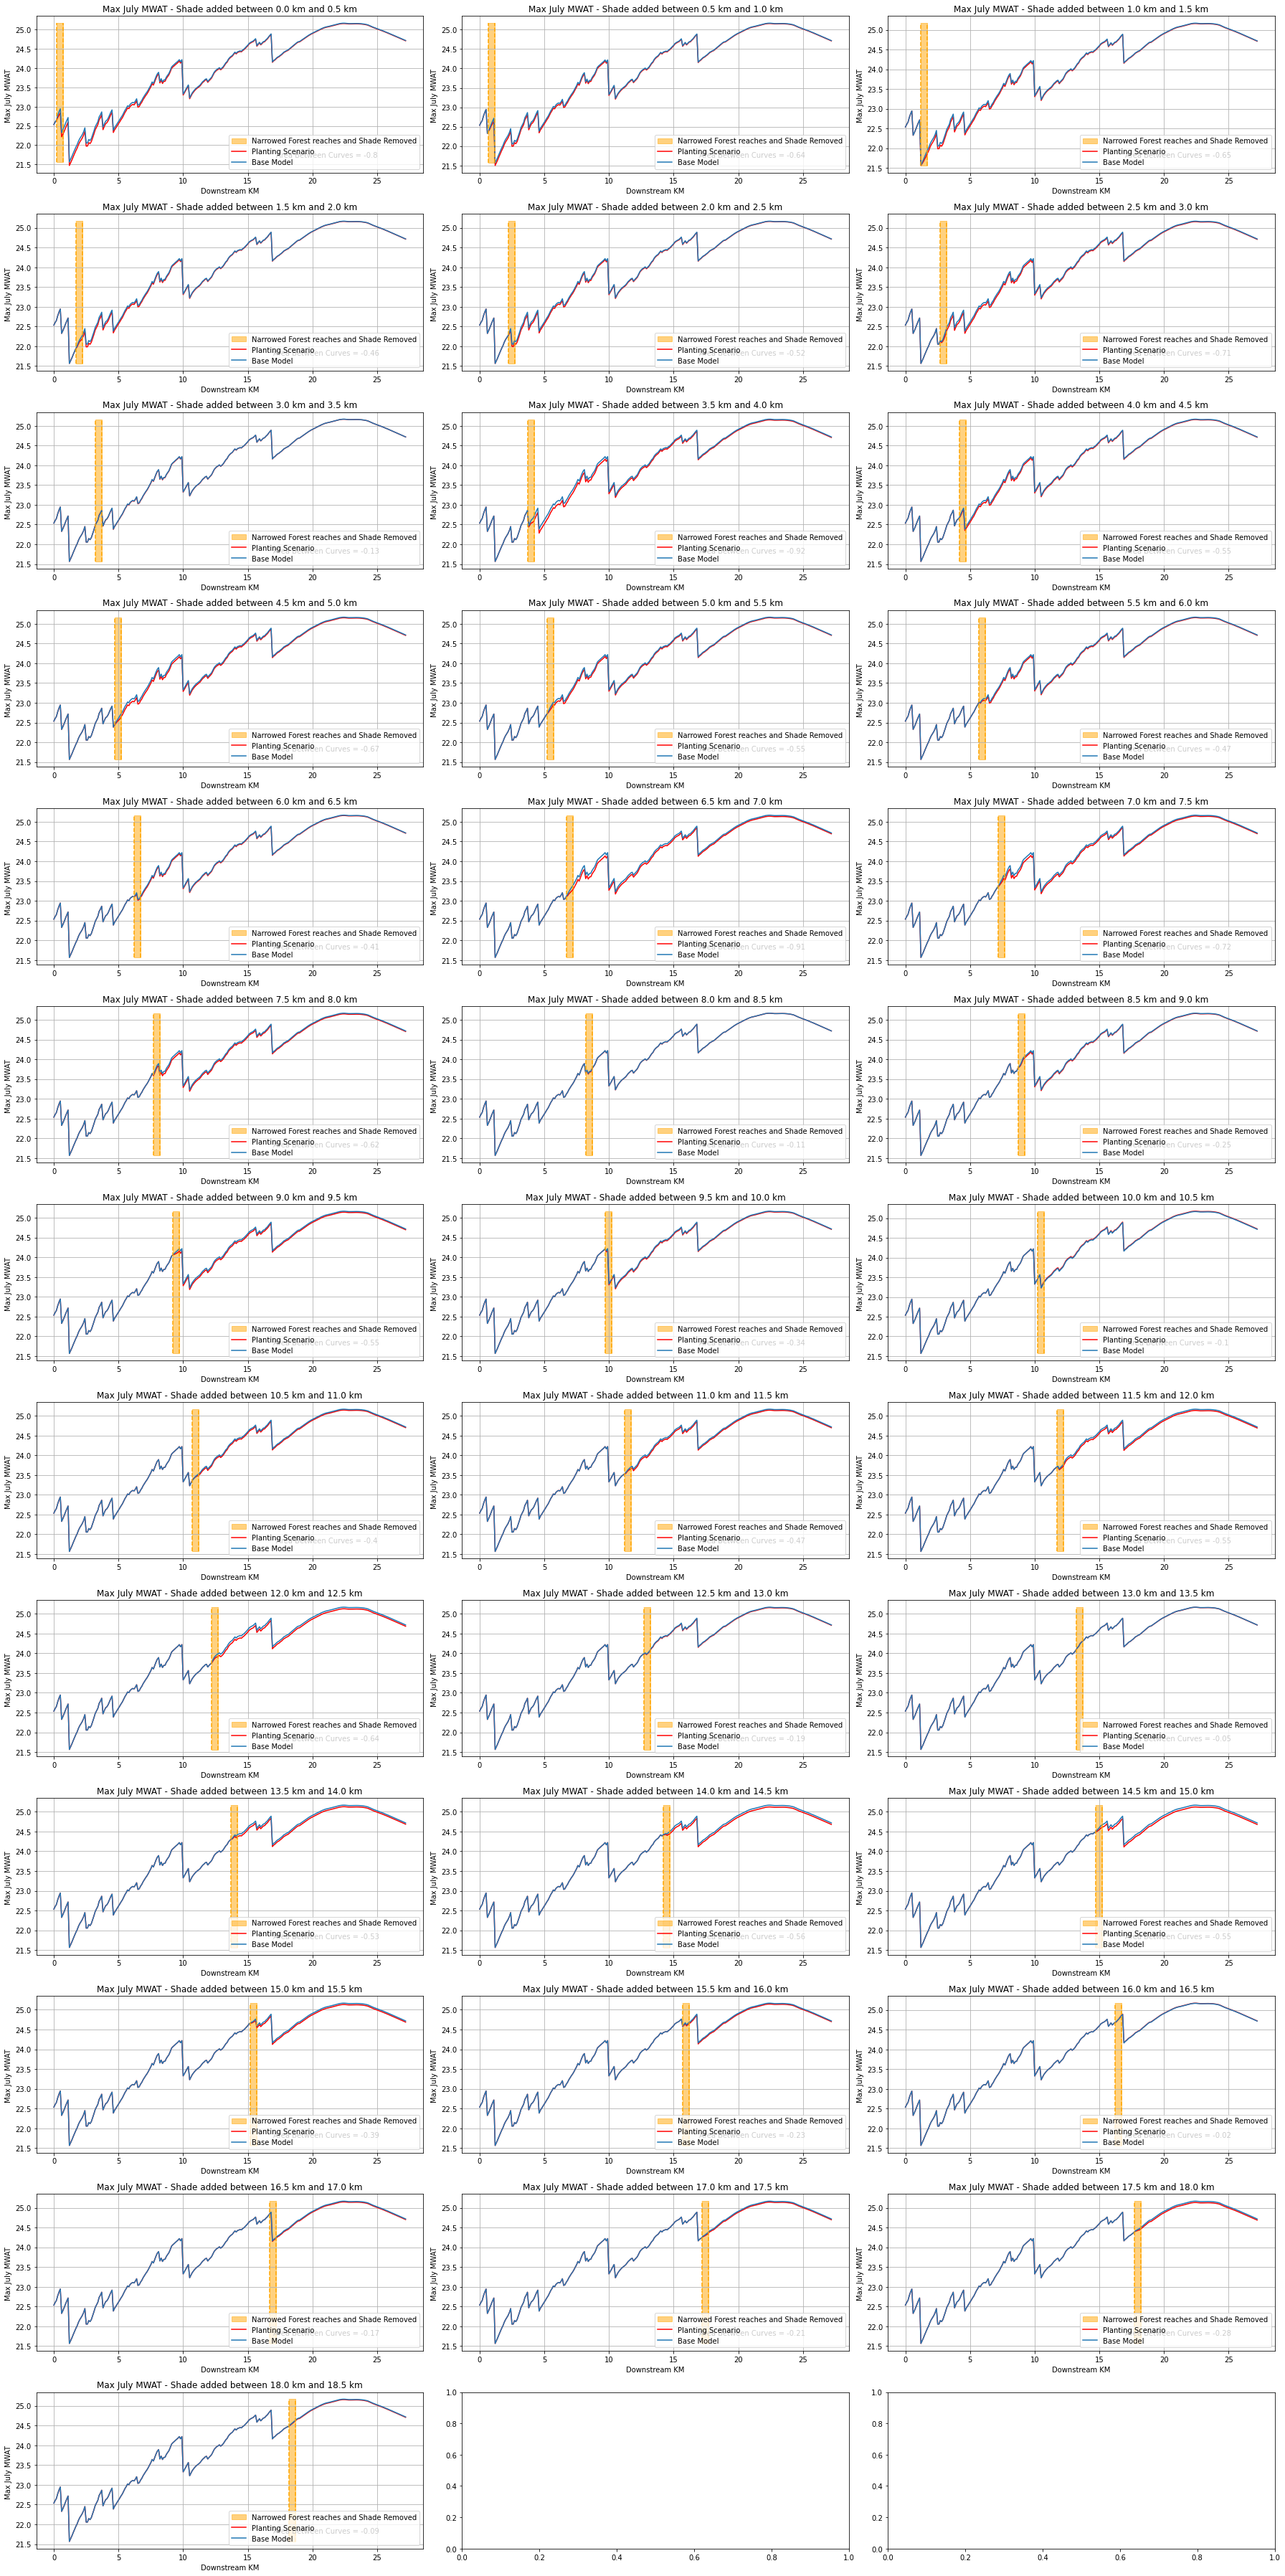

In [53]:
obs = pd.read_csv(r"D:\Ben_wd\THESIS\streamtemperature\WFK23\Summer23\mainstemhourly_km.csv")
obs["datetime"] = pd.to_datetime(obs["datetime"])
obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'08-01-2023')]# + pd.DateOffset(1))]


obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
obs_clip.drop(19.2, axis=1, inplace=True)
#plotting from bankbuffer
fig, axes = plt.subplots(13, 3, figsize=(25, 50))

    # Flatten the axes array to make it easier to iterate over
axes = axes.flatten()
hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='H', inclusive='left') 
daily_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left') 
#upstreamconstant_df = 
upstreamconstant_df = pd.read_csv(os.path.join(r'D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\extending_model\\allgrass_extended_monthly', 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 274))
upstreamconstant_df.columns = [float(col) for col in upstreamconstant_df.columns]
upstreamconstant_df.index = obs_clip.index
# mean july temperature summary
upstreamconstant_modeled_mean = upstreamconstant_df.resample('D').mean()

upstreamconstant_modeled = upstreamconstant_df.resample('D').mean()
# upstreamconstant_modeled = upstreamconstant_df.resample('D').sum()

upstreamconstant_modeled = upstreamconstant_modeled.mean()    
upstreamconstant_modeled = pd.DataFrame(upstreamconstant_modeled)
upstreamconstant_modeled = upstreamconstant_modeled.reset_index()
upstreamconstant_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)

obs_rolling_avg = upstreamconstant_modeled_mean.rolling(window=7).max()
obs_max_mwat = obs_rolling_avg.max()
upstreamconstant_modeled['Max MWAT'] = obs_max_mwat.values

#base shade scenario

base_shade_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Shade.csv'), skiprows=6, usecols=range(1, 274))
base_hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='H', inclusive='left')  # Closed left ensures end date is exclusive
base_shade_df.columns = [float(col) for col in base_shade_df.columns]
base_shade_df.index = daily_index
# base_shade_df.index = obs_clip.index

base_shade = base_shade_df.mean()
base_shade = pd.DataFrame(base_shade)
base_shade = base_shade.reset_index()
base_shade.rename(columns={'index': 'NODE_ID', 0 : 'Effective Shade %'}, inplace=True)

#discts to hold differneces between scenarios
effectiveness_difference = {}
reach_shade_base = {}
reach_shade_scenario = {}
reach_shade_change = {}
reach_velocity = {}
reach_width = {}
reach_depth = {}
reach_widthdepth = {}
reach_azimuth = {}
reach_gradient = {}
count = 0
for i in values:
    count += 1
    km_start = i
    km_end = i-.5
    if km_start == 0:
        continue
    else:
        # km_start = i+1
        # km_end = i
        reach_source_folder = f"D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\results\\monthly500m_treeplanting\\treeplanting_widening_{i}"
        modeled_tw_df = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 274))
        modeled_tw_df.columns = [float(col) for col in modeled_tw_df.columns]
        modeled_tw_df.index = obs_clip.index
        # mean july temperature summary
        mean_daily_modeled = modeled_tw_df.resample('D').mean()
        mean_july_modeled = mean_daily_modeled.mean()    
        mean_july_modeled = pd.DataFrame(mean_july_modeled)
        mean_july_modeled = mean_july_modeled.reset_index()
        mean_july_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)
        sim__rolling_avg = mean_daily_modeled.rolling(window=7).max()
        sim_max_mwat = sim__rolling_avg.max()
        mean_july_modeled['Max MWAT'] = sim_max_mwat.values
        # mwat = mean_daily_modeled.rolling(window=7).max()
        # mwat = mwat.max()
        # mwat = pd.DataFrame(mwat)
        # mean_july_modeled = pd.merge(mean_july_modeled, mwat[0], left_on='NODE_ID', right_index = True, how='left')
        # mean_july_modeled.rename(columns={0: 'Max MWAT'}, inplace=True) 
        
        #saving reach effectiveness
        # difference = mean_july_modeled['Mean July Temp'] - upstreamconstant_modeled['Mean July Temp']
        # norm_difference = difference/km_start
        # norm_difference = norm_difference.values.sum()
        # norm_effectiveness_difference[km_start] = norm_difference
        # effectiveness_difference[km_start] = difference.values.sum()
        
        #doing integration
        x = mean_july_modeled['NODE_ID']
        y1 = mean_july_modeled['Mean July Temp']
        y2 = upstreamconstant_modeled['Mean July Temp']

        
        
        
        
        # Compute absolute difference between the curves
        abs_diff = np.abs(y1 - y2)

        # Use Simpson's rule for numerical integration
        area = simps(abs_diff, x)
        #changing sign of degree kilomters to be negative or positive based on if its cooling (negative) or warming (positive) from restoration
        if (upstreamconstant_modeled - mean_july_modeled ).mean()['Mean July Temp'] <= 0:
            area = area*-1
        area
        #changing sign of degree kilomters to be negative or positive based on if its cooling (negative) or warming (positive) from restoration
        if (upstreamconstant_modeled - mean_july_modeled ).mean()['Mean July Temp'] <= 0:
            area = area*-1
        
        effectiveness_difference[km_start] = area
        
        #getting effective shade values
        control_file = pd.read_csv(os.path.join(base_source_folder, 'HeatSource_Control.csv'))
        cc_start = control_file.loc[7]['VALUE']
        cc_start = pd.to_datetime(cc_start)
        cc_end = control_file.loc[8]['VALUE']
        cc_end = pd.to_datetime(cc_end)
        scenario_shade_df = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Shade.csv'), skiprows=6, usecols=range(1, 274))
        # hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left')  # Closed left ensures end date is exclusive
        #         hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left')  # Closed left ensures end date is exclusive

        scenario_shade_df.columns = [float(col) for col in scenario_shade_df.columns]
        scenario_shade_df.index = daily_index
        shade = scenario_shade_df.mean()
        shade = pd.DataFrame(shade)
        shade = shade.reset_index()
        shade.rename(columns={'index': 'NODE_ID', 0 : 'Effective Shade %'}, inplace=True)
        reach = shade[(shade['NODE_ID'] <= km_start) & (shade['NODE_ID'] >=km_end)]
        base_reach = base_shade[(base_shade['NODE_ID'] <= km_start) & (base_shade['NODE_ID'] >=km_end)]
        #compare base shade to scenario shade
        reach_percent_increase = (base_reach - reach)/base_reach
        reach_difference = reach - base_reach

        reach_mean_percent_increase = reach_percent_increase['Effective Shade %'].mean()    
        #reach_shade[km_start] = reach_mean_percent_increase
        reach_shade_base[km_start] = base_reach['Effective Shade %'].mean()
        reach_shade_scenario[km_start] = reach['Effective Shade %'].mean()
        reach_shade_change[km_start] = reach_difference['Effective Shade %'].mean()

         #get reach azimuth
        azimuth = pd.read_csv('Channel_azimuth.csv')
        azimuth_reach = azimuth[(azimuth['STREAM_KM'] <= km_start) & (azimuth['STREAM_KM'] >=km_end)]
        azimuth_reach_mean = azimuth_reach['Azm'].mean()
        reach_azimuth[km_start] = abs(azimuth_reach_mean-180)
        
        #get reach gradient 
        gradient = pd.read_csv('Channel_azimuth.csv')
        gradient_reach = gradient[(gradient['STREAM_KM'] <= km_start) & (gradient['STREAM_KM'] >=km_end)]
        gradient_reach_mean = gradient_reach['GRADIENT'].mean()
        reach_gradient[km_start] = gradient_reach_mean

        #getting mean velocity
        velocity = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_Vel.csv'), skiprows=6, usecols=range(1, 274))
        velocity.columns = [float(col) for col in velocity.columns]
        sim_velocity = velocity.mean()#.to_numpy()
        sim_velocity = pd.DataFrame(sim_velocity)
        sim_velocity = sim_velocity.reset_index()
        sim_velocity.rename(columns={'index': 'NODE_ID', 0 : 'Velocity'}, inplace=True)
        velocity_reach = sim_velocity[(sim_velocity['NODE_ID'] <= km_start) & (sim_velocity['NODE_ID'] >=km_end)]
        reach_mean_velocity = velocity_reach['Velocity'].mean()
        reach_velocity[km_start] = reach_mean_velocity
        
        #Getting Width
        sim_width = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_WT.csv'), skiprows=6, usecols=range(1, 274))
        sim_width.columns = [float(col) for col in sim_width.columns]
        sim_width = sim_width.iloc[0]#.to_numpy()
        sim_width = pd.DataFrame(sim_width)
        sim_width = sim_width.reset_index()
        sim_width.rename(columns={'index': 'NODE_ID', 0 : 'Width'}, inplace=True)
        sim_width = sim_width[(sim_width['NODE_ID'] <= km_start) & (sim_width['NODE_ID'] >=km_end)]
        reach_width[km_start] = sim_width['Width'].mean()
        
        #getting depth
        sim_depth = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_DA.csv'), skiprows=6, usecols=range(1, 274))
        sim_depth.columns = [float(col) for col in sim_depth.columns]
        sim_depth = sim_depth.iloc[0]#.to_numpy()
        sim_depth = pd.DataFrame(sim_depth)
        sim_depth = sim_depth.reset_index()
        sim_depth.rename(columns={'index': 'NODE_ID', 0 : f'Depth'}, inplace=True)
        sim_depth = sim_depth[(sim_depth['NODE_ID'] <= km_start) & (sim_depth['NODE_ID'] >=km_end)]
        reach_depth[km_start] = sim_depth['Depth'].mean()
        #width:depth
        reach_widthdepth[km_start] = (sim_width['Width'].mean()/sim_depth['Depth'].mean())
        #plotting
        # Create a new figure with a 3x3 grid of subplots

        shade_start = i
        #plt.figure()  # Create a new figure for each iteration  
        axes[count-1].fill_between([27.2 - km_start, 27.2 - km_end], upstreamconstant_modeled['Max MWAT'].min(),upstreamconstant_modeled['Max MWAT'].max(), color='orange', alpha = .5, label = 'Narrowed Forest reaches and Shade Removed')
        axes[count-1].plot(27.2-mean_july_modeled['NODE_ID'], mean_july_modeled['Max MWAT'], label=f'Planting Scenario', color = 'red')
        axes[count-1].plot(27.2-upstreamconstant_modeled['NODE_ID'], upstreamconstant_modeled['Max MWAT'], label='Base Model')
        axes[count-1].set_title(f'Max July MWAT - Shade added between {27 - km_start} km and {27 - km_end} km')
        axes[count-1].set_xlabel('Downstream KM')  # Replace 'X Label' with appropriate label
        axes[count-1].set_ylabel('Max July MWAT ')  # Replace 'Y Label' with appropriate label
        axes[count-1].text(0.75, 0.1, f'Area Between Curves = {round(area,2)}', horizontalalignment='center', transform=axes[count-1].transAxes)

        # Plot the shade data on the second y-axis
        # axes[count-1] = axes[count-1].twinx()
        # axes[count-1].plot(27.2-shade.index, shade[0], label='Mean Solar Radiation Flux \n At Stream Surface', color='red', alpha = .5)
        # axes[count-1].set_ylabel('Mean Solar Radiation Flux \n At Stream Surface (W/m2)', color = 'red')
        # axes[count-1].tick_params(axis='y', colors='red')

        axes[count-1].vlines([27.2 - km_start, 27.2 - km_end], ymin = upstreamconstant_modeled['Max MWAT'].min(), ymax = upstreamconstant_modeled['Max MWAT'].max(),color = 'orange', linestyles = 'dashed')
        axes[count-1].grid(True) 
        axes[count-1].legend(loc = 'lower right')

        #axes[count-1].legend(loc = 'lower right')
        # axes[count-1].set_xlim([18.3 - km_end-2, 18.3 - km_start+2 ])


    #plt.show()
    #add vertical line where shade is added              
plt.tight_layout()
fig.patch.set_facecolor('white')

#plt.savefig(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/500m_run/narrow/reach_shaderemoval+narrow20.png')
plt.show()
#new_folder_name = f"folder_{km_start}"

In [79]:
#read in 500m reaches shapefile
nodes = gpd.read_file(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/shp/restoration_reaches500m.shp')
nodes

reach_shadescenario_dict = pd.DataFrame(list(reach_shade_scenario.items()), columns=['Reach Start KM', 'SR Scenario'])
reach_shadebase_dict = pd.DataFrame(list(reach_shade_base.items()), columns=['Reach Start KM', 'SR Baseline'])
reach_velocity_dict = pd.DataFrame(list(reach_velocity.items()), columns=['Reach Start KM', 'Velocity'])
reach_width_dict = pd.DataFrame(list(reach_width.items()), columns=['Reach Start KM', 'Width'])
reach_depth_dict = pd.DataFrame(list(reach_depth.items()), columns=['Reach Start KM', 'Depth'])
reach_widthdepth_dict = pd.DataFrame(list(reach_widthdepth.items()), columns=['Reach Start KM', 'Width:Depth'])
reach_shadedif_dict = pd.DataFrame(list(reach_shade_change.items()), columns=['Reach Start KM', 'SR Difference'])
reach_azimuth_dict = pd.DataFrame(list(reach_azimuth.items()), columns=['Reach Start KM', 'Mean Azimuth'])
reach_gradient_dict = pd.DataFrame(list(reach_gradient.items()), columns=['Reach Start KM', 'Gradient'])



#creating df to add to 
dif_df_dict = pd.DataFrame(list(effectiveness_difference.items()), columns=['Reach Start KM', 'Degree Kilometers'])

#adding data from scenarios
dif_df_dict['Model Start KM'] = dif_df_dict['Reach Start KM']
dif_df_dict['Reach Start KM'] = dif_df_dict['Reach Start KM']-9
dif_df_dict['Mean velocity'] = reach_velocity_dict['Velocity']
dif_df_dict['Mean Azimuth'] = reach_azimuth_dict['Mean Azimuth']
dif_df_dict['Width'] = reach_width_dict['Width']
dif_df_dict['Depth'] = reach_depth_dict['Depth']
dif_df_dict['Width:Depth'] = reach_widthdepth_dict['Width:Depth']
dif_df_dict['Change in SR'] = reach_shadedif_dict['SR Difference']*100
dif_df_dict['Baseline SR'] = reach_shadebase_dict['SR Baseline'] *100
dif_df_dict['Scenario SR'] = reach_shadescenario_dict['SR Scenario']*100
dif_df_dict['absolute DK'] = abs(dif_df_dict['Degree Kilometers'])
dif_df_dict['Gradient'] = reach_gradient_dict['Gradient']

dif_df_dict['row'] = dif_df_dict.index+1


dif_df_dict.drop(dif_df_dict.tail(1).index, inplace=True)
dif_df_dict['Distance Downstream'] = 18.0 - dif_df_dict['Reach Start KM']
dif_df_dict = dif_df_dict.sort_values('Degree Kilometers')
dif_df_dict.reset_index(drop=True, inplace=True)
dif_df_dict.index.name = 'Effectiveness Rank'
dif_df_dict.reset_index(inplace=True)
dif_df_dict.index += 1
merged_gdf_dif = pd.merge(nodes, dif_df_dict[['Reach Start KM','Degree Kilometers', 'row','absolute DK','Effectiveness Rank', 'Width', 'Baseline SR', 'Change in SR', 'Mean velocity']], left_on='row', right_on = 'row', how='left')
#merged_gdf_dif.drop(merged_gdf_dif['row'], axis=0, errors='ignore')

#merged_gdf_dif.to_file(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/extending_model/ranking_treeremoval.shp')
dif_df_dict.sort_values(by = 'Effectiveness Rank')

Effectiveness Rank  Reach Start KM  Degree Kilometers  Model Start KM  \
1                    0            14.5          -0.920688            23.5   
2                    1            11.5          -0.907517            20.5   
3                    2            18.0          -0.802969            27.0   
4                    3            11.0          -0.723421            20.0   
5                    4            15.5          -0.707907            24.5   
6                    5            13.5          -0.673401            22.5   
7                    6            17.0          -0.649373            26.0   
8                    7            17.5          -0.643013            26.5   
9                    8             6.0          -0.640907            15.0   
10                   9            10.5          -0.618016            19.5   
11                  10             4.0          -0.563036            13.0   
12                  11             3.5          -0.553642            12.5   
13                  12             9.0          -0.550064            18.0   
14                  13            13.0          -0.548240            22.0   
15                  14            14.0          -0.545288            23.0   
16                  15             6.5          -0.545062            15.5   
17                  16             4.5          -0.527959            13.5   
18                  17            16.0          -0.522902            25.0   
19                  18            12.5          -0.474591            21.5   
20                  19             7.0          -0.468400            16.0   
21                  20            16.5          -0.457807            25.5   
22                  21            12.0          -0.407236            21.0   
23                  22             7.5          -0.397017            16.5   
24                  23             3.0          -0.394913            12.0   
25                  24             8.5          -0.344813            17.5   
26                  25             0.5          -0.284573             9.5   
27                  26             9.5          -0.252532            18.5   
28                  27             2.5          -0.233010            11.5   
29                  28             1.0          -0.212630            10.0   
30                  29             5.5          -0.188094            14.5   
31                  30             1.5          -0.173695            10.5   
32                  31            15.0          -0.134685            24.0   
33                  32            10.0          -0.109688            19.0   
34                  33             8.0          -0.104028            17.0   
35                  34             5.0          -0.050577            14.0   
36                  35             2.0          -0.022244            11.0   

    Mean velocity  Mean Azimuth      Width     Depth  Width:Depth  \
1        0.202317      8.212636  15.013950  0.197483    76.026416   
2        0.167233      6.466463  13.706600  0.407583    33.628951   
3        0.188333     25.251616   9.043867  0.233017    38.812102   
4        0.214117     20.746725  16.299900  0.233883    69.692439   
5        0.123333     55.458476  15.588433  0.273183    57.062168   
6        0.210400     51.823624  12.391817  0.269467    45.986455   
7        0.139867      8.798597  10.821867  0.318533    33.974048   
8        0.162833     44.509351   8.952717  0.276733    32.351421   
9        0.201283      5.208694  19.474333  0.309083    63.006740   
10       0.246983     37.957450  18.804317  0.175050   107.422546   
11       0.217117      6.226988  13.095500  0.396017    33.068053   
12       0.131950     38.432298  14.811667  0.942233    15.719744   
13       0.297917     13.581165  11.541633  0.232567    49.627204   
14       0.182833     12.565303  14.033833  0.510383    27.496653   
15       0.156267     37.249117  14.864983  0.302767    49.097160   
16       0.205333      1.960584  14.051200  0.3953

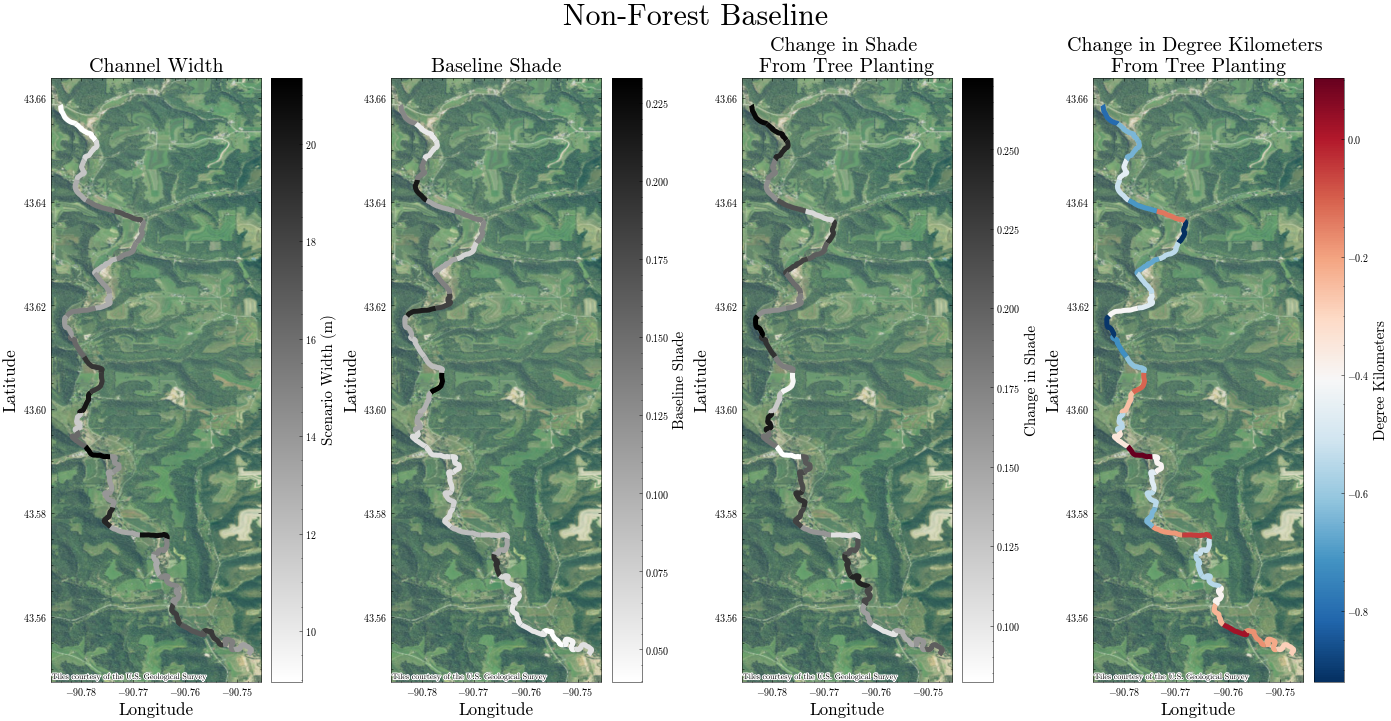

In [39]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx
import scienceplots

# Define the original colormap
original_cmap = plt.cm.gray
degree_cmap = plt.cm.RdBu
inverted_degree_cmap = degree_cmap.reversed()

# Invert the colormap
inverted_cmap = original_cmap.reversed()

# Define the boundaries for the colorbar steps
bounds_width = [merged_gdf_dif['Width'].min(), merged_gdf_dif['Width'].max()]  
bounds_dif = [merged_gdf_dif['Baseline SR'].min(), merged_gdf_dif['Baseline SR'].max()]
bounds_changeSR = [merged_gdf_dif['Change in SR'].min(), merged_gdf_dif['Change in SR'].max()]

# Create a colormap norm with the defined boundaries
norm1 = mcolors.Normalize(vmin=merged_gdf_dif['Width'].min(), vmax=merged_gdf_dif['Width'].max())
norm2 = mcolors.Normalize(vmin=merged_gdf_dif['Baseline SR'].min(), vmax=merged_gdf_dif['Baseline SR'].max())
norm3 = mcolors.Normalize(vmin=merged_gdf_dif['Change in SR'].min(), vmax=merged_gdf_dif['Change in SR'].max())
norm4 = mcolors.Normalize(vmin=merged_gdf_dif['Degree Kilometers'].min(), vmax=merged_gdf_dif['Degree Kilometers'].max())

with plt.style.context(['science', 'no-latex']):
    # plotting the difference in temps between modeled reaches, with ranking
    fig, axes = plt.subplots(1, 4, figsize=(20, 10),layout = 'compressed')
    fig.suptitle('Non-Forest Baseline', fontsize=30)

    db_lonlat = merged_gdf_dif.to_crs(epsg=4326)
    #ctx.add_basemap(axes[0], crs=db_lonlat.crs)
    
    # Plot the first map
    ax1 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Width', cmap=inverted_cmap, linewidth=5, ax=axes[0], norm=norm1)
    ctx.add_basemap(ax1, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax1.set_xlabel('Longitude', fontsize=17)
    ax1.set_ylabel('Latitude', fontsize=17)
    ax1.set_title('Channel Width', fontsize=20)

    # Plot the second map
    ax2 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Baseline SR', cmap=inverted_cmap, linewidth=5, ax=axes[1], norm=norm2)
    ctx.add_basemap(ax2, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax2.set_title('Baseline Shade', fontsize=20)
    ax2.set_xlabel('Longitude', fontsize=17)
    ax2.set_ylabel('Latitude', fontsize=17)
    
    ax3 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Change in SR', cmap=inverted_cmap, linewidth=5, ax=axes[2], norm=norm3)
    ctx.add_basemap(ax3, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax3.set_title('Change in Shade \nFrom Tree Planting', fontsize=20)
    ax3.set_xlabel('Longitude', fontsize=17)
    ax3.set_ylabel('Latitude', fontsize=17)
    
    ax4 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Degree Kilometers', cmap=inverted_degree_cmap, linewidth=5, ax=axes[3], norm=norm4)
    ctx.add_basemap(ax4, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax4.set_title('Change in Degree Kilometers \nFrom Tree Planting', fontsize=20)
    ax4.set_xlabel('Longitude', fontsize=17)
    ax4.set_ylabel('Latitude', fontsize=17)


    # Add colorbars for clarity
    cbar1 = plt.colorbar(mappable=cm.ScalarMappable(norm=norm1, cmap=inverted_cmap), ax=axes[0], orientation='vertical')
    cbar1.set_label('Scenario Width (m)', fontsize=15)

    cbar2 = plt.colorbar(mappable=cm.ScalarMappable(norm=norm2, cmap=inverted_cmap), ax=axes[1], orientation='vertical')
    cbar2.set_label('Baseline Shade', fontsize=15)
    
    cbar3 = plt.colorbar(mappable=cm.ScalarMappable(norm=norm3, cmap=inverted_cmap), ax=axes[2], orientation='vertical')
    cbar3.set_label('Change in Shade', fontsize=15)
    
    cbar4 = plt.colorbar(mappable=cm.ScalarMappable(norm=norm4, cmap=inverted_degree_cmap), ax=axes[3], orientation='vertical')
    cbar4.set_label('Degree Kilometers', fontsize=15)

    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\500mTreePlantingEffectiveness.png', bbox_inches='tight', dpi=300)
    plt.show()


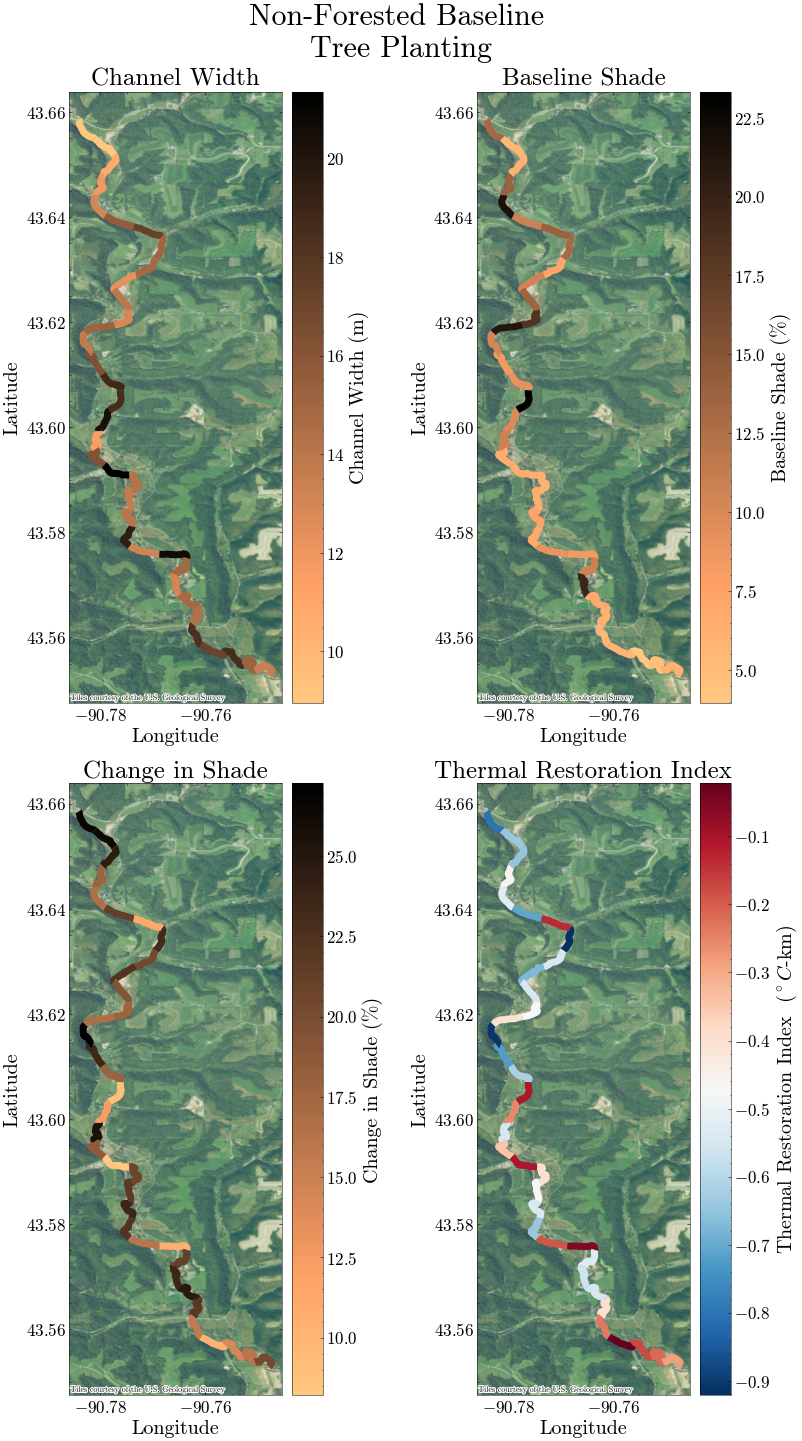

In [91]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx
import scienceplots


# Define the original colormap
original_cmap = plt.cm.copper
degree_cmap = plt.cm.RdBu
inverted_degree_cmap = degree_cmap.reversed()

# Invert the colormap
inverted_cmap = original_cmap.reversed()

# Define the boundaries for the colorbar steps
bounds_width = [merged_gdf_dif['Width'].min(), merged_gdf_dif['Width'].max()]  
bounds_dif = [merged_gdf_dif['Baseline SR'].min(), merged_gdf_dif['Baseline SR'].max()]
bounds_changeSR = [merged_gdf_dif['Change in SR'].min(), merged_gdf_dif['Change in SR'].max()]

# Create a colormap norm with the defined boundaries
norm1 = mcolors.Normalize(vmin=merged_gdf_dif['Width'].min(), vmax=merged_gdf_dif['Width'].max())
norm2 = mcolors.Normalize(vmin=merged_gdf_dif['Baseline SR'].min(), vmax=merged_gdf_dif['Baseline SR'].max())
norm3 = mcolors.Normalize(vmin=merged_gdf_dif['Change in SR'].min(), vmax=merged_gdf_dif['Change in SR'].max())
norm4 = mcolors.Normalize(vmin=merged_gdf_dif['Degree Kilometers'].min(), vmax=merged_gdf_dif['Degree Kilometers'].max())

with plt.style.context(['science', 'no-latex']):
    # plotting the difference in temps between modeled reaches, with ranking
    fig, axes = plt.subplots(2, 2, figsize=(40, 20), layout = 'compressed')
    fig.suptitle('Non-Forested Baseline \nTree Planting', fontsize=30)

    db_lonlat = merged_gdf_dif.to_crs(epsg=4326)
    #ctx.add_basemap(axes[0], crs=db_lonlat.crs)
    
    # Plot the first map
    ax1 = axes.flat[0]

    #ax1 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Width', cmap=inverted_cmap, linewidth=5, ax=axes[0], norm=norm1)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Width', cmap=inverted_cmap, linewidth=7, ax=ax1, norm=norm1)

    ctx.add_basemap(ax1, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax1.set_xlabel('Longitude', fontsize = 20)
    ax1.set_ylabel('Latitude', fontsize=20)
    ax1.set_title('Channel Width', fontsize=25)
    ax1.tick_params(axis='both', which='major', labelsize=17)

    # Plot the second map
    ax2 = axes.flat[1]

    # ax2 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Baseline SR', cmap=inverted_cmap, linewidth=5, ax=axes[1], norm=norm2)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Baseline SR', cmap=inverted_cmap, linewidth=7, ax=ax2, norm=norm2)

    ctx.add_basemap(ax2, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax2.set_title('Baseline Shade', fontsize=25)
    ax2.set_xlabel('Longitude', fontsize=20)
    ax2.set_ylabel('Latitude', fontsize=20)
    ax2.tick_params(axis='both', which='major', labelsize=17)

    
    ax3 = axes.flat[2]

    # ax3 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Change in SR', cmap=inverted_cmap, linewidth=5, ax=axes[2], norm=norm3)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Change in SR', cmap=inverted_cmap, linewidth=7, ax=ax3, norm=norm3)

    ctx.add_basemap(ax3, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax3.set_title('Change in Shade', fontsize=25)
    ax3.set_xlabel('Longitude', fontsize=20)
    ax3.set_ylabel('Latitude', fontsize=20)
    ax3.tick_params(axis='both', which='major', labelsize=17)

    ax4 = axes.flat[3]

    # ax4 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Degree Kilometers', cmap=inverted_degree_cmap, linewidth=5, ax=axes[3], norm=norm4)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Degree Kilometers', cmap=inverted_degree_cmap, linewidth=7, ax=ax4, norm=norm4)

    ctx.add_basemap(ax4, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax4.set_title('Thermal Restoration Index', fontsize=25)
    ax4.set_xlabel('Longitude', fontsize=20)
    ax4.set_ylabel('Latitude', fontsize=20)
    ax4.tick_params(axis='both', which='major', labelsize=17)

    # Add colorbars for clarity
    # cbar1 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm1, cmap=inverted_cmap), ax=axes[0], orientation='vertical')
    cbar1 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm1, cmap=inverted_cmap), ax=ax1, orientation='vertical')
    cbar1.set_label('Channel Width (m)', fontsize=20)
    cbar1.ax.tick_params(axis='both', which='major', labelsize=17)


    cbar2 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm2, cmap=inverted_cmap), ax=ax2, orientation='vertical')
    cbar2.set_label('Baseline Shade (%)', fontsize=20)
    cbar2.ax.tick_params(axis='both', which='major', labelsize=17)

    cbar3 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm3, cmap=inverted_cmap), ax=ax3, orientation='vertical')
    cbar3.set_label('Change in Shade (%)', fontsize=20)
    cbar3.ax.tick_params(axis='both', which='major', labelsize=17)

    cbar4 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm4, cmap=inverted_degree_cmap), ax=ax4, orientation='vertical')
    cbar4.set_label('Thermal Restoration Index  (${^\circ}C$-km)', fontsize=20)
    cbar4.ax.tick_params(axis='both', which='major', labelsize=17)

    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\500mTreePlantingEffectiveness.png', bbox_inches='tight', dpi=300)
    plt.show()


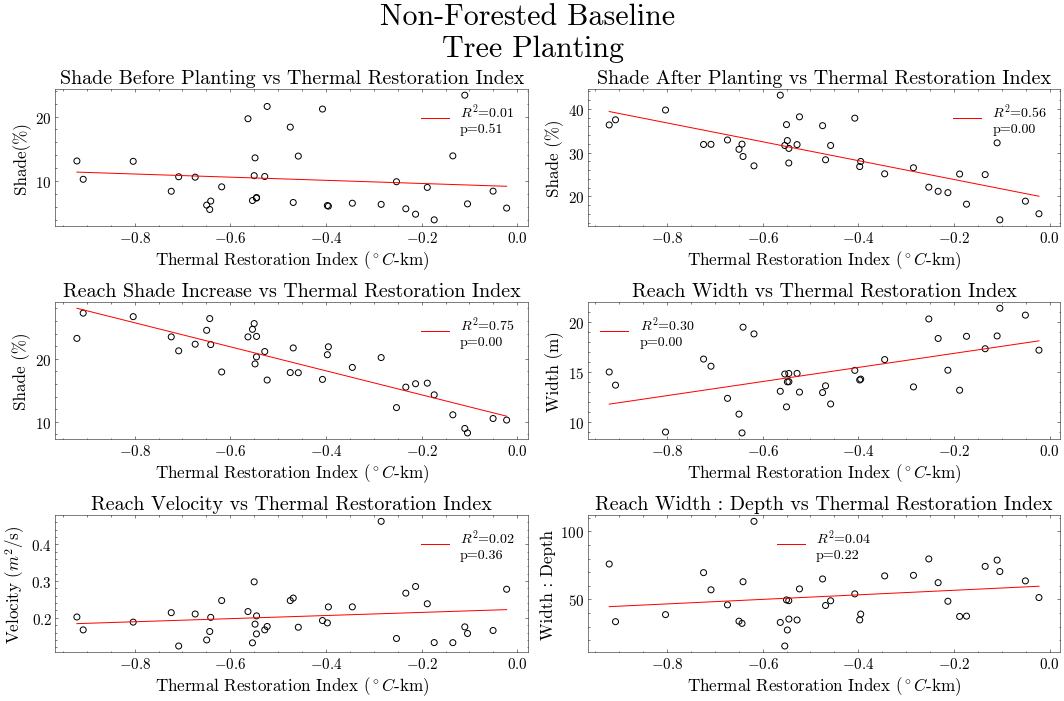

In [93]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

# Assuming dif_df_dict contains your data

# Define a function for plotting
def plot_scatter_and_regression(x_data, y_data, x_label, y_title, y_label, ax):
    with plt.style.context(['science', 'no-latex']):
        #x_data = x_data*-1
        # Fitting linear regression
        model = LinearRegression()
        model.fit(x_data, y_data)
        r_squared = model.score(x_data, y_data)

        # Calculate p-value
        slope, intercept, r_value, p_value, std_err = linregress(x_data.ravel(), y_data)

        # Scatter plot
        ax.scatter(x_data, y_data, facecolors='none', edgecolors='black')

        # Plotting the regression line
        ax.plot(x_data, model.predict(x_data), color='red', linestyle = '-',label=f'$R^2$={r_squared:.2f} \np={p_value:.2f}')
        ax.set_title(y_title+ ' vs Thermal Restoration Index', fontsize = 20)
        # Labels and legend
        ax.set_xlabel(x_label, fontsize = 17)
        ax.set_ylabel(y_label, fontsize = 17)
        ax.tick_params(axis='both', which='major', labelsize=15)

        ax.legend(fontsize = 14)
with plt.style.context(['science', 'no-latex']):
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    fig.suptitle('Non-Forested Baseline \nTree Planting', fontsize=30)

    # Plot 1
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Baseline SR'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Shade Before Planting',  'Shade(%)', axs[0, 0])

    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Scenario SR'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Shade After Planting', 'Shade (%)', axs[0, 1])

    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Change in SR'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Shade Increase', 'Shade (%)', axs[1, 0])

    # Plot 2 (Assuming you have dif_df_dict2, dif_df_dict3, dif_df_dict4 for other data)
    # Adjust accordingly based on your actual data
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Width'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Width', 'Width (m)', axs[1, 1])

    # Plot 3
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                dif_df_dict['Mean velocity'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Velocity', 'Velocity ($m{^2}$/s)', axs[2, 0])

    # Plot 4
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Width:Depth'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Width : Depth', 'Width : Depth', axs[2, 1])

    # Adjust layout
    plt.tight_layout()
    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\500mTreePlantingEffectiveness_scatter.png', bbox_inches = 'tight', dpi = 300)
    # Show plot
    plt.show()

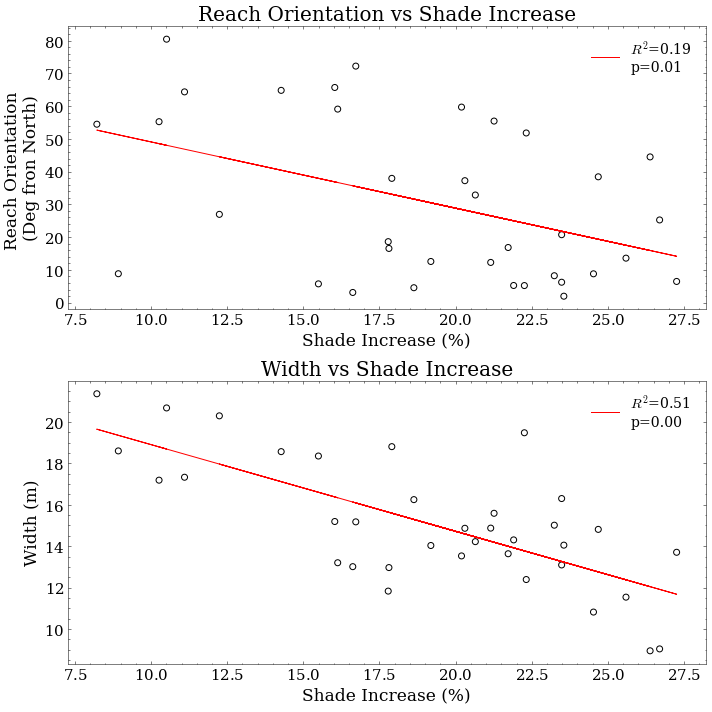

In [86]:
# Define a function for plotting
def plot_scatter_and_regression(x_data, y_data, x_label, y_title, y_label, ax):
    with plt.style.context(['science', 'no-latex']):
        #x_data = x_data*-1
        # Fitting linear regression
        model = LinearRegression()
        model.fit(x_data, y_data)
        r_squared = model.score(x_data, y_data)

        # Calculate p-value
        slope, intercept, r_value, p_value, std_err = linregress(x_data.ravel(), y_data)

        # Scatter plot
        ax.scatter(x_data, y_data, facecolors='none', edgecolors='black')

        # Plotting the regression line
        ax.plot(x_data, model.predict(x_data), color='red', linestyle = '-',label=f'$R^2$={r_squared:.2f} \np={p_value:.2f}')
        ax.set_title(y_title + ' vs Shade Increase', fontsize = 20)
        # Labels and legend
        ax.set_xlabel(x_label, fontsize = 17)
        ax.set_ylabel(y_label, fontsize = 17)
        ax.tick_params(axis='both', which='major', labelsize=15)

        ax.legend(fontsize = 14)

with plt.style.context(['science', 'no-latex']):
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    #fig.suptitle('Influence of Width \nand Channel Orientation on Shade', fontsize=30)

    # Plot 1
    plot_scatter_and_regression(dif_df_dict['Change in SR'].values.reshape(-1, 1),
                                 dif_df_dict['Mean Azimuth'].values,
                                 'Shade Increase (%)', 'Reach Orientation', 'Reach Orientation \n(Deg fron North)', axs[0])
    #plot 2
    plot_scatter_and_regression(dif_df_dict['Change in SR'].values.reshape(-1, 1),
                                 dif_df_dict['Width'].values,
                                 'Shade Increase (%)', 'Width', 'Width (m)', axs[1])
    plt.tight_layout()
    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\Orientation_width_effectiveness.png', bbox_inches = 'tight', dpi = 300)


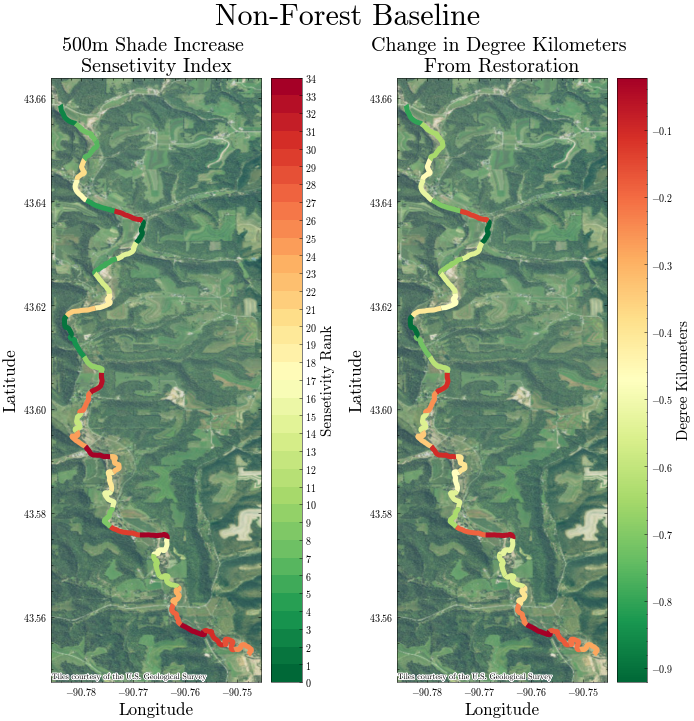

In [35]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx
import scienceplots
# Define the original colormap
original_cmap = plt.cm.RdYlGn

# Invert the colormap
inverted_cmap = original_cmap.reversed()

# Define the boundaries for the colorbar steps
bounds = list(range(0, 35))  # Example boundaries
bounds_dif = [merged_gdf_dif['Degree Kilometers'].min(), merged_gdf_dif['Degree Kilometers'].max()]

# Create a colormap norm with the defined boundaries
norm = mcolors.BoundaryNorm(bounds, inverted_cmap.N)

# Create a colormap norm with the defined boundaries for the second plot
norm2 = mcolors.Normalize(vmin=merged_gdf_dif['Degree Kilometers'].min(), vmax=merged_gdf_dif['Degree Kilometers'].max())
with plt.style.context(['science', 'no-latex']):

    # plotting the difference in temps between modeled reaches, with ranking
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), layout = 'compressed')
    fig.suptitle('Non-Forest Baseline', fontsize=30)



    db_lonlat = merged_gdf_dif.to_crs(epsg=4326)
    #ctx.add_basemap(ax, crs=db_lonlat.crs)
    # Plot the first map
    ax1 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Effectiveness Rank', cmap=inverted_cmap, linewidth=5, ax=axes[0], norm=norm)
    ctx.add_basemap(ax1, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax1.set_xlabel('Longitude', fontsize = 17)
    ax1.set_ylabel('Latitude', fontsize = 17)
    ax1.set_title('500m Shade Increase \nSensetivity Index', fontsize = 20)

    # Plot the second map
    ax2 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Degree Kilometers', cmap=inverted_cmap, linewidth=5,ax=axes[1], norm=norm2)
    ctx.add_basemap(ax2, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax2.set_title('Change in Degree Kilometers \nFrom Restoration', fontsize = 20)
    ax2.set_xlabel('Longitude', fontsize = 17)
    ax2.set_ylabel('Latitude', fontsize = 17)
    # Add colorbars for clarity
    cbar1 = plt.colorbar(mappable=axes[0].collections[0], ax=axes[0], orientation='vertical', boundaries=bounds, ticks=bounds)
    cbar1.set_label('Sensetivity Rank', fontsize = 15)

    cbar2 = plt.colorbar(mappable=axes[1].collections[0], ax=axes[1], orientation='vertical')
    cbar2.set_label('Degree Kilometers', fontsize = 15)
    plt.subplots_adjust(wspace=0)  # Adjust the width space between subplots

    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\500mTreePlantingEffectiveness.png', bbox_inches = 'tight', dpi = 300)
    plt.show()


In [ ]:
### Plotting Change in Hours above MWAT Threshold

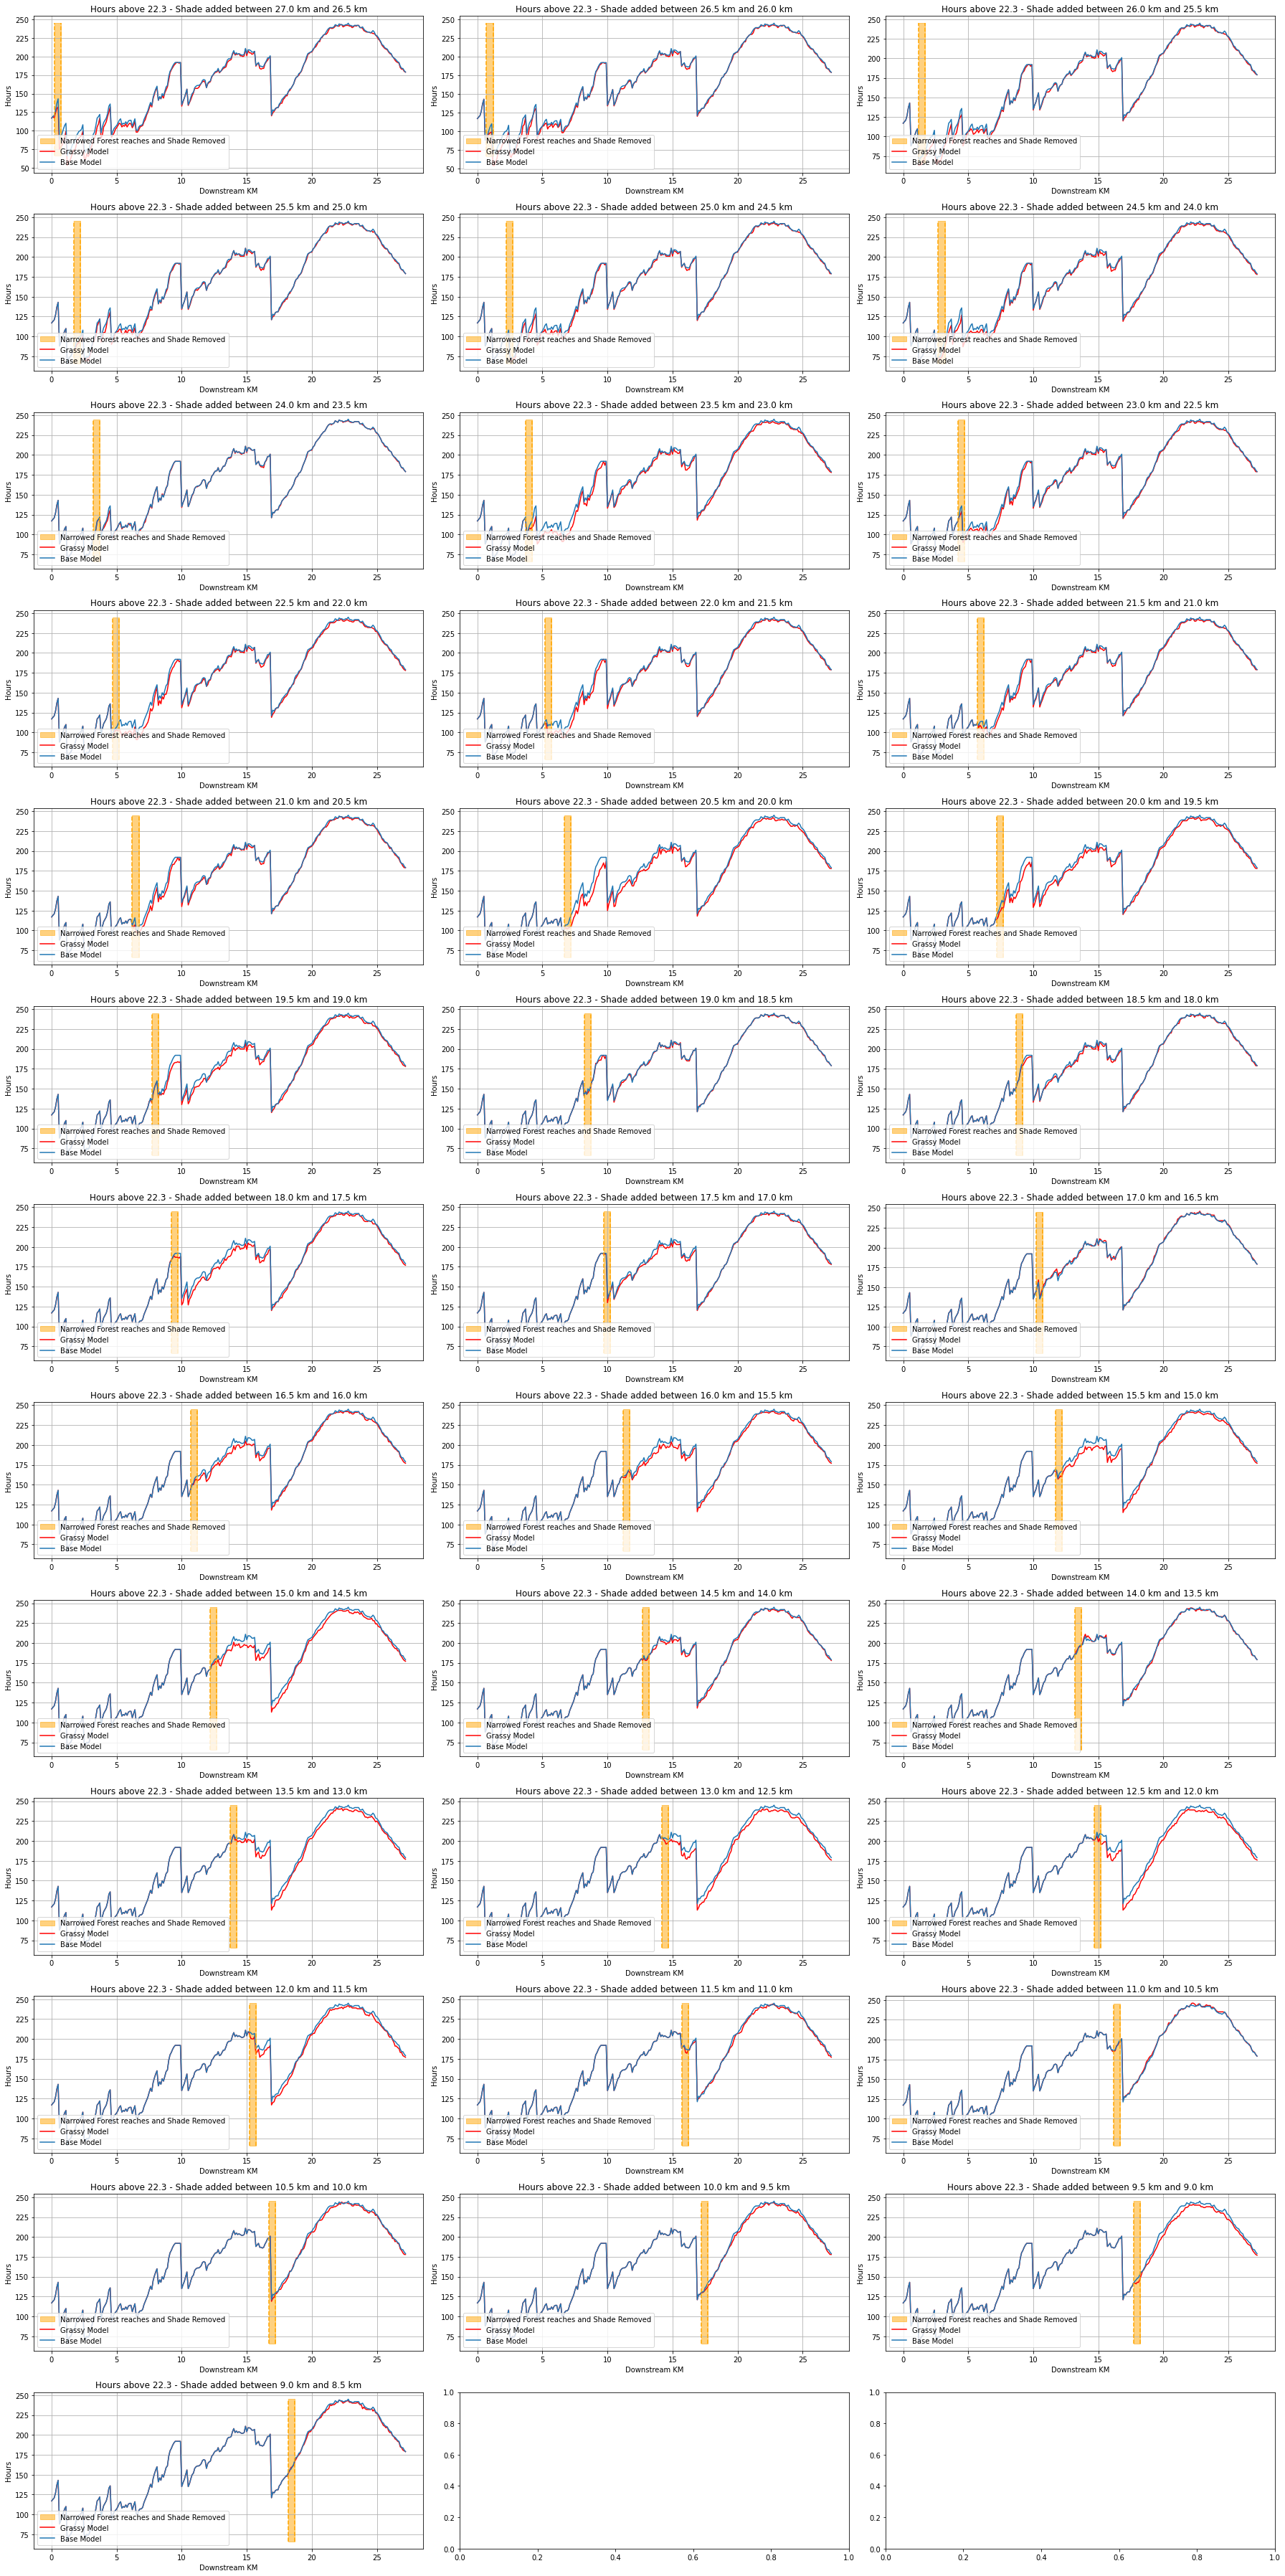

In [200]:
upstreamconstant_df = pd.read_csv(os.path.join(r'D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\extending_model\\allgrass_extended_monthly', 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 274))
upstreamconstant_df.columns = [float(col) for col in upstreamconstant_df.columns]
upstreamconstant_df.index = obs_clip.index
# mean july temperature summary
upstreamconstant_modeled = upstreamconstant_df.resample('D').mean()
# upstreamconstant_modeled = upstreamconstant_df.resample('D').sum()

upstreamconstant_modeled = upstreamconstant_modeled.mean()    
upstreamconstant_modeled = pd.DataFrame(upstreamconstant_modeled)
upstreamconstant_modeled = upstreamconstant_modeled.reset_index()
upstreamconstant_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)
base_hours_above_25 = upstreamconstant_df.apply(lambda col: (col > 23.3).sum())
base_hours_above_25 = pd.DataFrame(base_hours_above_25)

upstreamconstant_modeled = pd.merge(upstreamconstant_modeled, base_hours_above_25, left_on = 'NODE_ID', right_index = True, how = 'left')
upstreamconstant_modeled.rename(columns={0: 'hrs above 25'}, inplace=True)


count = 0
fig, axes = plt.subplots(13, 3, figsize=(25, 50))

    # Flatten the axes array to make it easier to iterate over
axes = axes.flatten()
for i in values:
    count += 1
    km_start = i
    km_end = i-.5
    if km_start == 0:
        continue
    else:
        # km_start = i+1
        # km_end = i
        reach_source_folder =  f"D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\results\\monthly500m_treeplanting\\treeplanting_widening_{i}"
        modeled_tw_df = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 274))
        modeled_tw_df.columns = [float(col) for col in modeled_tw_df.columns]
        modeled_tw_df.index = obs_clip.index
        mean_daily_modeled = modeled_tw_df.resample('D').mean()
        mean_july_modeled = mean_daily_modeled.mean()    
        mean_july_modeled = pd.DataFrame(mean_july_modeled)
        mean_july_modeled = mean_july_modeled.reset_index()
        mean_july_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)
        hours_above_25 = modeled_tw_df.apply(lambda col: (col > 23.3).sum())
        hours_above_25 = pd.DataFrame(hours_above_25)

        mean_july_modeled = pd.merge(mean_july_modeled, hours_above_25, left_on = 'NODE_ID', right_index = True, how = 'left')
        mean_july_modeled.rename(columns={0: 'hrs above 25'}, inplace=True)
        shade_start = i
        #plt.figure()  # Create a new figure for each iteration  
        axes[count-1].fill_between([27.2 - km_start, 27.2 - km_end], upstreamconstant_modeled['hrs above 25'].min(),upstreamconstant_modeled['hrs above 25'].max(), color='orange', alpha = .5, label = 'Narrowed Forest reaches and Shade Removed')
        axes[count-1].plot(27.2-mean_july_modeled['NODE_ID'], mean_july_modeled['hrs above 25'], label=f'Grassy Model', color = 'red')
        axes[count-1].plot(27.2-upstreamconstant_modeled['NODE_ID'], upstreamconstant_modeled['hrs above 25'], label='Base Model')
        axes[count-1].set_title(f'Hours above 22.3 - Shade added between {km_start} km and {km_end} km')
        axes[count-1].set_xlabel('Downstream KM')  # Replace 'X Label' with appropriate label
        axes[count-1].set_ylabel('Hours')  # Replace 'Y Label' with appropriate label


        axes[count-1].vlines([27.2 - km_start, 27.2 - km_end], ymin = upstreamconstant_modeled['hrs above 25'].min(), ymax = upstreamconstant_modeled['hrs above 25'].max(),color = 'orange', linestyles = 'dashed')
        axes[count-1].grid(True) 
        axes[count-1].legend(loc = 'lower left') 
        
plt.tight_layout()
fig.patch.set_facecolor('white')

#plt.savefig(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/500m_run/narrow/reach_shaderemoval+narrow20.png')
plt.show()
